In [1]:
from numpy import genfromtxt
import matplotlib.pyplot as plt
#!pip install mplfinance
import mplfinance as mpf
from mplfinance.original_flavor import candlestick2_ochl, candlestick_ohlc
import numpy as np
import pandas as pd
import uuid
import time
import shutil
import os
import sys
from datetime import datetime
from packaging import version

#import tensorflow as tf
#from tensorflow import keras
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras

from keras import optimizers
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Conv2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

#!pip install opencv-python
import cv2

%load_ext tensorboard

data = "data2"
train = data + "/train/"
validation=  data + "/validation/"
buy = "buy/"
sell = "sell/"

Using plaidml.keras.backend backend.


In [3]:
n_samples = len(os.listdir(train+buy)) + len(os.listdir(train+sell))

# get image dimensions
img_path = os.listdir(data + "/train/buy")[10]
im = cv2.imread(data + "/train/buy/" + img_path)

# create arrays
buy_array = np.empty((len(os.listdir(train+buy)), im.shape[0], im.shape[1], 3))
sell_array = np.empty((len(os.listdir(train+sell)), im.shape[0], im.shape[1], 3))


# fill buy array
files = os.listdir(train + buy)
for i, f in enumerate(files):
    if f.endswith(".png"):
        im = cv2.imread("data2/train/buy/" + f)
        buy_array[i] = keras.preprocessing.image.img_to_array(im)
buy_array /= 255
        
# fill sell array
files = os.listdir(train + sell)
for i, f in enumerate(files):
    if f.endswith(".png"):
        im = cv2.imread("data2/train/sell/" + f)
        sell_array[i] = keras.preprocessing.image.img_to_array(im)
sell_array /= 255


# combine and shuffle arrays
np.random.seed(42)
x_train = np.append(buy_array, sell_array, axis=0)
y_train = np.append(np.ones(len(buy_array)), np.zeros(len(sell_array)))
p = np.random.permutation(len(x_train))
x_train = x_train[p]
y_train = y_train[p]

In [27]:
img_width = im.shape[0]
img_height = im.shape[1]


# Enter the number of samples, training + validation
nb_filters1 = 32
nb_filters2 = 32
nb_filters3 = 64
conv1_size = 3
conv2_size = 2
conv3_size = 5
pool_size = 2
# We have 2 classes, buy and sell
classes_num = 2
batch_size = 128
chanDim = 3



### custom model
model = Sequential()
model.add(Convolution2D(nb_filters1, conv1_size, padding ='same', input_shape=(img_width, img_height , 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(0.5))

model.add(Convolution2D(nb_filters2, conv2_size, padding ="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size), data_format='channels_last'))
model.add(Dropout(0.5))

model.add(Convolution2D(nb_filters3, conv3_size, padding ='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size), data_format='channels_last'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(),
                      metrics=['accuracy'])

callbacks_list = [
    #OneCycle(min_lr=7e-6, max_lr=7e-2, min_mtm = 0.85, max_mtm = 0.95, annealing_stage=0.1, annealing_rate=0.01, training_iterations=np.ceil(((183*epochs)/(batch_size)))),
    #keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss" ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 140, 144, 32)      896       
_________________________________________________________________
activation_33 (Activation)   (None, 140, 144, 32)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 70, 72, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 70, 72, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 70, 72, 32)        4128      
_________________________________________________________________
activation_34 (Activation)   (None, 70, 72, 32)        0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 35, 36, 32)        0         
__________

In [28]:
# original - 95% training - 50% validation - overfitting
# added 0.1 dropout after each moxpooling and changed from image_generator to numpy array - 15 epochs - 95% training - 50% validation - still overfitting
# increased each conv dropout to 0.25 - 20 epochs - 96% training - 50% validation - still overfitting
# increased each conv dropout to 0.50 - 20 epochs - 84% training - 50% validation - still overfitting
history = model.fit(x_train, y_train, epochs=20, verbose=1, batch_size=128, shuffle=True, callbacks=callbacks_list, validation_split=0.2)

model.save("my_model")

Train on 8509 samples, validate on 2128 samples
Epoch 1/20
8509/8509 [==============================] - 71s 8ms/step - loss: 0.7527 - acc: 0.5089 - val_loss: 0.6932 - val_acc: 0.4962
Epoch 2/20
8509/8509 [==============================] - 61s 7ms/step - loss: 0.6929 - acc: 0.5155 - val_loss: 0.6933 - val_acc: 0.4962
Epoch 3/20
8509/8509 [==============================] - 61s 7ms/step - loss: 0.6920 - acc: 0.5159 - val_loss: 0.6932 - val_acc: 0.4962
Epoch 4/20
8509/8509 [==============================] - 61s 7ms/step - loss: 0.6914 - acc: 0.5220 - val_loss: 0.6929 - val_acc: 0.5202
Epoch 5/20
8509/8509 [==============================] - 61s 7ms/step - loss: 0.6903 - acc: 0.5361 - val_loss: 0.6925 - val_acc: 0.5287
Epoch 6/20
8509/8509 [==============================] - 62s 7ms/step - loss: 0.6887 - acc: 0.5412 - val_loss: 0.6923 - val_acc: 0.5202
Epoch 7/20
8509/8509 [==============================] - 61s 7ms/step - loss: 0.6854 - acc: 0.5466 - val_loss: 0.6927 - val_acc: 0.5301
Epoch 8

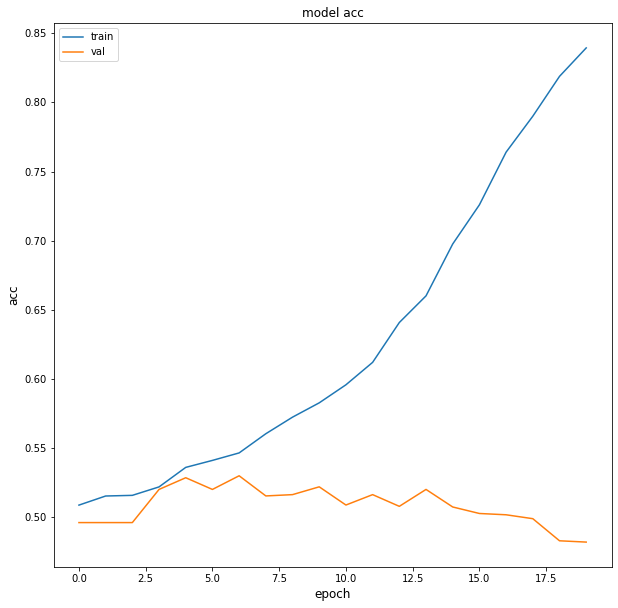

In [31]:
# show traning/validation plots
metric = "acc"
plt.figure(figsize=(10,10))
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [13]:
y_pred = model.predict(x_train)

In [14]:
keras.metrics.binary_accuracy(y_train, y_pred)

AttributeError: 'tuple' object has no attribute 'dims'

In [16]:
y_train.shape

(10637,)